In [45]:
def gini(solution, submission):
    df = zip(solution, submission)
    df = sorted(df, key=lambda x: (x[1],x[0]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    solution=np.array(solution)
    submission=np.array(submission)
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import preprocessing
import xgboost as xgb

%pylab inline --no-import-all

In [1]:
#load train and test 
train  = pd.read_csv('data/train.csv', index_col=0)
test  = pd.read_csv('data/test.csv', index_col=0)

labels = train.Hazard
train.drop('Hazard', axis=1, inplace=True)


columns = train.columns
test_ind = test.index

train = np.array(train)
test = np.array(test)

# label encode the categorical variables
for i in range(train.shape[1]):
    if type(train[1,i]) is str:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[:,i]) + list(test[:,i]))
        train[:,i] = lbl.transform(train[:,i])
        test[:,i] = lbl.transform(test[:,i])

train = train.astype(float)
test = test.astype(float)

params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.01
params["min_child_weight"] = 5
params["subsample"] = 0.8
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 7

plst = list(params.items())

#Using 5000 rows for early stopping. 
offset = 5000

num_rounds = 2000
xgtest = xgb.DMatrix(test)

#create a train and validation dmatrices 
xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

#train using early stopping and predict
watchlist = [(xgtrain, 'train'),(xgval, 'val')]
model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
preds1 = model.predict(xgtest)
print("gini score on training set"+str(normalized_gini(labels,model.predict(xgb.DMatrix(train)))))

#reverse train and labels and use different 5k for early stopping. 
# this adds very little to the score but it is an option if you are concerned about using all the data. 
train = train[::-1,:]
labels = labels[::-1]

xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

watchlist = [(xgtrain, 'train'),(xgval, 'val')]
model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
preds2 = model.predict(xgtest)
print("gini score on training set"+str(normalized_gini(labels,model.predict(xgb.DMatrix(train)))))

#combine predictions
#since the metric only cares about relative rank we don't need to average
preds = preds1 + preds2

#generate solution
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('xgboost_benchmark.csv')

Will train until val error hasn't decreased in 5 rounds.
[0]	train-rmse:5.325511	val-rmse:5.268591
[1]	train-rmse:5.299678	val-rmse:5.243596
[2]	train-rmse:5.274328	val-rmse:5.218745
[3]	train-rmse:5.249436	val-rmse:5.194481
[4]	train-rmse:5.225020	val-rmse:5.170586
[5]	train-rmse:5.200645	val-rmse:5.146721
[6]	train-rmse:5.176841	val-rmse:5.123450
[7]	train-rmse:5.153202	val-rmse:5.100384
[8]	train-rmse:5.129744	val-rmse:5.077728
[9]	train-rmse:5.106841	val-rmse:5.055594
[10]	train-rmse:5.084411	val-rmse:5.033685
[11]	train-rmse:5.062215	val-rmse:5.011999
[12]	train-rmse:5.040394	val-rmse:4.990659
[13]	train-rmse:5.018893	val-rmse:4.969793
[14]	train-rmse:4.997688	val-rmse:4.948999
[15]	train-rmse:4.976818	val-rmse:4.928491
[16]	train-rmse:4.956389	val-rmse:4.908632
[17]	train-rmse:4.935981	val-rmse:4.889282
[18]	train-rmse:4.915811	val-rmse:4.869623
[19]	train-rmse:4.895864	val-rmse:4.850812
[20]	train-rmse:4.876412	val-rmse:4.831973
[21]	train-rmse:4.857146	val-rmse:4.813540
[22]	tr

Populating the interactive namespace from numpy and matplotlib


[395]	train-rmse:3.516667	val-rmse:3.731405
Stopping. Best iteration:
[390]	train-rmse:3.519702	val-rmse:3.731265



NameError: name 'normalized_gini' is not defined

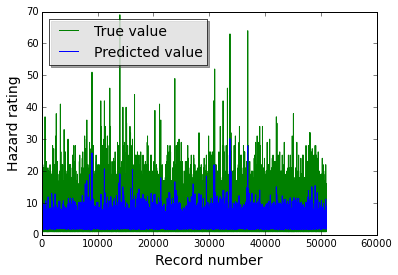

In [3]:
# Plot predicted and true interarrival times on the training set

plt.plot(labels, color="green", label="True value")
plt.plot(model.predict(xgb.DMatrix(train)), label="Predicted value")

plt.xlabel("Record number", fontsize=14)
plt.ylabel("Hazard rating", fontsize=14)
plt.legend(frameon=True, shadow=True, framealpha=0.7, loc=0, prop={"size": 14})